In [23]:
# For deep learning and computer vision
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks  

# For data handling & visualization
import numpy as np  
import matplotlib.pyplot as plt  
import os  
import pathlib  

# For performance metrics
from sklearn.metrics import classification_report, confusion_matrix  
import seaborn as sns

# Your subsequent code will go here...

2.19.0


In [38]:
import pathlib

data_root = pathlib.Path('/home/tannaz/Develop/PYProjects/Oil_Spill/dataset')

# Ensure the main dataset directory exists
if not data_root.exists():
    print(f"Creating main dataset directory: {data_root}")
    data_root.mkdir(parents=True, exist_ok=True)

# Define split names
splits = ['train', 'validation', 'test']
for split in splits:
    base = data_root / split
    print(f"Checking in: {base}")
    
    # Create the split directory if it doesn't exist
    if not base.exists():
        print(f"Creating split directory: {base}")
        base.mkdir(exist_ok=True)
    
    oil_spill_path = base / 'Oil Spill'
    non_oil_path = base / 'Non Oil Spill'

    # Create subdirectories if they do not exist
    if not oil_spill_path.exists():
        print(f"Creating directory: {oil_spill_path}")
        oil_spill_path.mkdir(parents=True, exist_ok=True)
        
    if not non_oil_path.exists():
        print(f"Creating directory: {non_oil_path}")
        non_oil_path.mkdir(parents=True, exist_ok=True)
    
    # Now check the contents of the directories (should be empty initially)
    print(f"{split} — Oil spill:", len(list(oil_spill_path.iterdir())),
          "| Non Oil:", len(list(non_oil_path.iterdir())))


Checking in: /home/tannaz/Develop/PYProjects/Oil_Spill/dataset/train
train — Oil spill: 1400 | Non Oil: 1400
Checking in: /home/tannaz/Develop/PYProjects/Oil_Spill/dataset/validation
validation — Oil spill: 0 | Non Oil: 0
Checking in: /home/tannaz/Develop/PYProjects/Oil_Spill/dataset/test
test — Oil spill: 300 | Non Oil: 300


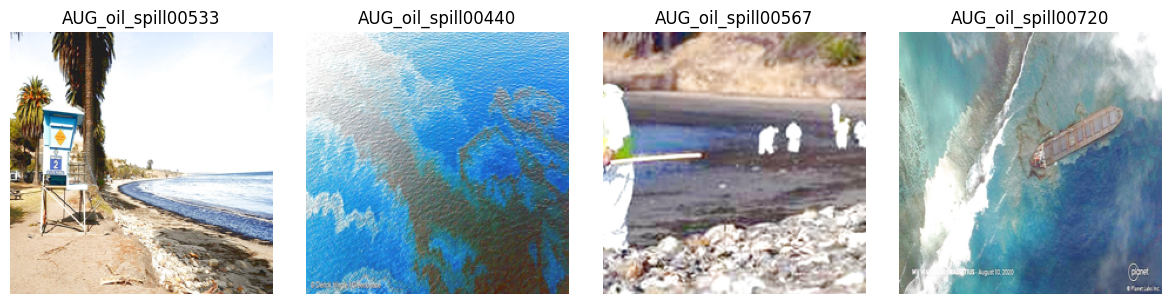

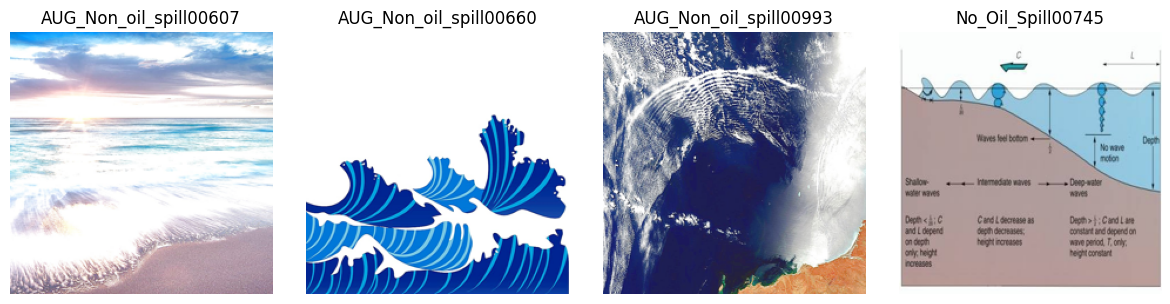

In [39]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

def plot_samples(folder, n=4):
    imgs = list(Path(folder).glob('*'))[:n]
    if not imgs:
        print(f"No images found in folder: {folder}")
        return

    plt.figure(figsize=(n*3, 3))
    for i, img_path in enumerate(imgs):
        try:
            img = Image.open(img_path).resize((224, 224))
            plt.subplot(1, n, i+1)
            plt.imshow(img)
            plt.title(img_path.stem)
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    plt.tight_layout()
    plt.show()

# Use it
plot_samples(data_root / 'train' / 'Oil Spill')
plot_samples(data_root / 'train' / 'Non Oil Spill')


In [40]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(data_root/'train', 
                                         target_size=IMG_SIZE, 
                                         batch_size=BATCH_SIZE,
                                         class_mode='binary')

val_ds = val_test_gen.flow_from_directory(data_root/'Validation', 
                                          target_size=IMG_SIZE,
                                          batch_size=BATCH_SIZE,
                                          class_mode='binary')

test_ds = val_test_gen.flow_from_directory(data_root/'test', 
                                           target_size=IMG_SIZE, 
                                           batch_size=BATCH_SIZE,
                                           class_mode='binary',
                                           shuffle=False)


Found 2800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [41]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze pretrained layers

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [46]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import os

# Set your dataset path
data_root = Path("/home/tannaz/Develop/PYProjects/Oil_Spill/dataset")

# Create training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_root / "train",
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_root / "Validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary'
)

# Optional: Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Simple CNN model for binary classification
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=3, factor=0.5)

# Train the model
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early, reduce_lr]
)


Found 2800 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Epoch 1/20


/home/tannaz/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-07-20 09:58:10.026821: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44302336 exceeds 10% of free system memory.
2025-07-20 09:58:10.047166: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44302336 exceeds 10% of free system memory.
2025-07-20 09:58:10.061324: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44302336 exceeds 10% of free system memory.
2025-07-20 09:58:11.317507: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44302336 exceeds 10% of free system memory.
2025-07-20 09:58:12.219156: W external/local_xla/xla/tsl/framework

88/88 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.5959 - loss: 0.6915 - val_accuracy: 0.6750 - val_loss: 0.6197 - learning_rate: 1.0000e-04
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.7433 - loss: 0.5432 - val_accuracy: 0.7633 - val_loss: 0.5127 - learning_rate: 1.0000e-04
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.8159 - loss: 0.4129 - val_accuracy: 0.8183 - val_loss: 0.4298 - learning_rate: 1.0000e-04
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8427 - loss: 0.3532 - val_accuracy: 0.8500 - val_loss: 0.3559 - learning_rate: 1.0000e-04
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8983 - loss: 0.2658 - val_accuracy: 0.8750 - val_loss: 0.3105 - learning_rate: 1.0000e-04
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9209 - loss: 0.2172 - val_accuracy: 0.9150 - val_loss: 0.2498 - learning_rate: 1.0000e-04
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9524 - loss: 0.1

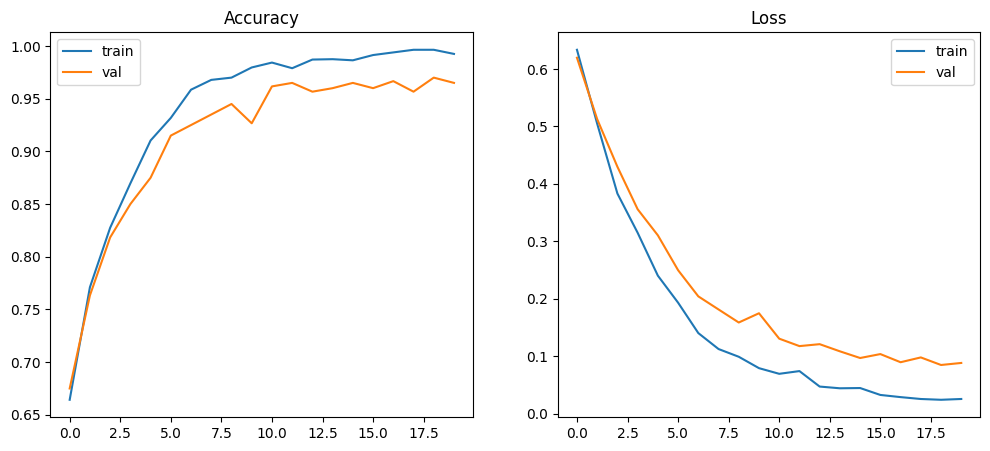

In [47]:
# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss'); plt.legend()
plt.show()



In [49]:
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load test dataset safely
test_ds = image_dataset_from_directory(
    data_root / "test",
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary',
    shuffle=False  # important for correct order
)

# Collect true labels
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Predict
preds = model.predict(test_ds)
y_pred = (preds > 0.5).astype(int).reshape(-1)


Found 600 files belonging to 2 classes.


2025-07-20 11:09:34.554968: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 398ms/step


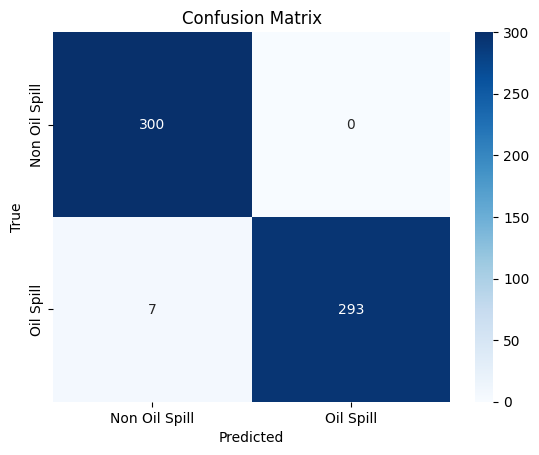

               precision    recall  f1-score   support

Non Oil Spill       0.98      1.00      0.99       300
    Oil Spill       1.00      0.98      0.99       300

     accuracy                           0.99       600
    macro avg       0.99      0.99      0.99       600
 weighted avg       0.99      0.99      0.99       600



In [50]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


In [53]:
def predict_image(image_path, model, img_size=IMG_SIZE):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    pred = model.predict(np.expand_dims(arr, axis=0))[0][0]
    label = 'Oil Spill' if pred > 0.5 else 'No Oil Spill'
    print(f"Prediction: {label} (confidence: {pred:.3f})")
    return pred


In [54]:
# Unfreeze all layers
base_model.trainable = True

# OPTIONAL: Freeze all layers *except* the top few (e.g., last 50)
fine_tune_at = 100  # Layer index to start fine-tuning from
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [55]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR!
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [56]:
fine_tune_epochs = 10
total_epochs = len(history.history['accuracy']) + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    validation_data=val_ds,
    callbacks=[early, reduce_lr]
)


Epoch 21/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9985 - loss: 0.0164 - val_accuracy: 0.9650 - val_loss: 0.0947 - learning_rate: 1.0000e-05
Epoch 22/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9986 - loss: 0.0154 - val_accuracy: 0.9667 - val_loss: 0.0894 - learning_rate: 1.0000e-05
Epoch 23/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9991 - loss: 0.0141 - val_accuracy: 0.9650 - val_loss: 0.0922 - learning_rate: 1.0000e-05
Epoch 24/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9998 - loss: 0.0130 - val_accuracy: 0.9683 - val_loss: 0.0880 - learning_rate: 1.0000e-05
Epoch 25/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9990 - loss: 0.0125 - val_accuracy: 0.9683 - val_loss: 0.0851 - learning_rate: 1.0000e-05
Epoch 26/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9998 - loss: 0.0116 - val_accuracy: 0.9667 - val_loss: 0.0923 - learning_rate: 1.0000e-05
Epoch 27/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 

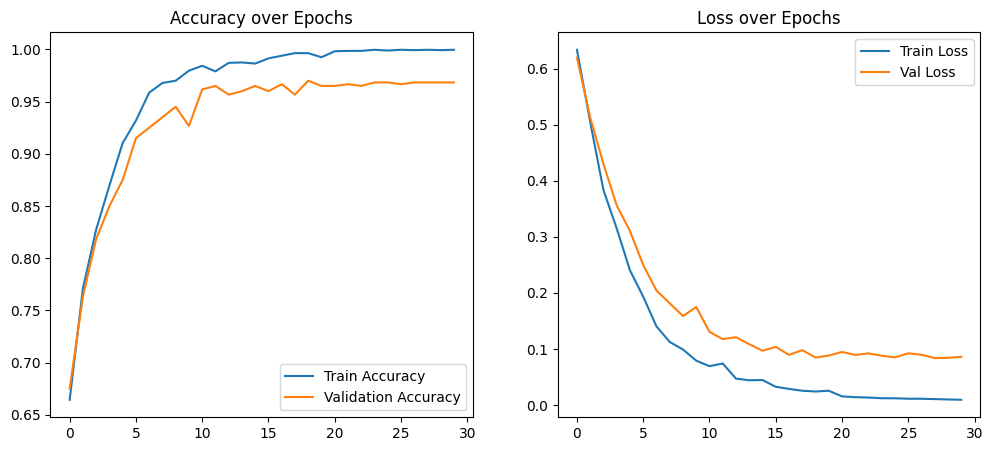

In [57]:
# Merge training histories
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(); plt.title('Accuracy over Epochs')

plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend(); plt.title('Loss over Epochs')
plt.show()


In [58]:
model.save("oil_spill_detector_finetuned.h5")
